<a href="https://colab.research.google.com/github/DimpleB0501/SecureNPrivateAIScholarshipCodes/blob/master/DeepLearningwithPyTorch/fashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torch import optim
from torch import nn

In [0]:
print ("Pytorch version:", torch.__version__)

Pytorch version: 1.1.0


# GPU mode initialize 

In [0]:
# Check if GPU available
if torch.cuda.is_available():
  print ("On GPU")
else :
  print ("On CPU")

On GPU


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading Fashion MNIST dataset

In [0]:

# Define a transform to normalize the data
trainTransform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Use the same transform for the validation data
validTransform = trainTransform

# Download the training and test data
trainSet = FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=trainTransform)
validSet = FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=validTransform)

# Load the training and test data
trainLoader = DataLoader(trainSet, batch_size=256, num_workers=0, shuffle=True)
validLoader = DataLoader(validSet, batch_size=512, num_workers=0, shuffle=False)


0it [00:00, ?it/s]

26427392it [00:00, 78391633.83it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 495362.98it/s]
  2%|▏         | 98304/4422102 [00:00<00:04, 905194.19it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 22309238.14it/s]                         
8192it [00:00, 136467.31it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
print (trainSet.train_data.shape)
print (validSet.test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


# Printing first 5 FashionMNIST dataset images and their labels

In [0]:
#Creating a label dictionary
labelDict = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal',6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot' } 

In [0]:
def plotImages (X, labels):
  #Plot the first 5 images and their labels
  for i, (img, y) in enumerate(zip(X, labels)):  
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(labelDict[y])

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


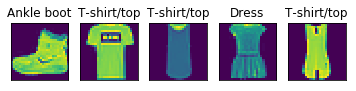

In [0]:

plotImages (trainSet.train_data[0:5], trainSet.train_labels[0:5].numpy())

# Progress monitor

In [0]:
from IPython.display import HTML, display

class ProgressMonitor(object):
    """
    Custom IPython progress bar for training
    """
    
    tmpl = """
        <p>Loss: {loss:0.4f}   {value} / {length}</p>
        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
    """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))


# Save model

In [0]:
def saveCheckpoint(model, epoch, filename):
    checkpoint_dict = {        
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)

# Load model

In [0]:
def loadCheckpoint(filename):        
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    stateDict = model.load_state_dict(checkpoint_dict['model'])    
    return epoch

# Implementing Lenet

In [0]:
class Lenet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0, bias=True)
    self.fc1   = nn.Linear(120,84)
    self.fc2   = nn.Linear(84,10)
    # Dropout module with 0.2 drop probability
    self.dropout = nn.Dropout(p=0.2)
  
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = self.dropout(F.relu(self.conv2(x)))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = x.view(-1, 120)
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x), dim = 1)
    
    return x
    

In [0]:
model = Lenet5()
model.to(device)
#model
#criterion = nn.NLLLoss() # Accuracy on this model was 90.428 at 15 epochs
criterion = nn.CrossEntropyLoss() #15 epochs 90.400%
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Create a directory called checkpoints


In [0]:
!rm -rf checkpoints
!mkdir -p checkpoints
!ls

checkpoints  sample_data


In [0]:
def train(optimizer, model, num_epochs=10, first_epoch=1):      
  trainLosses = []
  validLosses = []
  for epoch in range(first_epoch, first_epoch + num_epochs):
    print("Epoch: {}/{}.. ".format(epoch, num_epochs))
    # train phase
    model.train()

    # create a progress bar
    progress = ProgressMonitor(length=len(trainSet))     

    runningLoss = 0
    for images, labels in trainLoader:
      # Move the training data to the GPU
      images = images.to(device)
      labels = labels.to(device)

      # clear previous gradient computation
      optimizer.zero_grad()

      # forward propagation
      predictions = model(images)

      # calculate the loss
      loss = criterion(predictions, labels)

      # backpropagate to compute gradients
      loss.backward()

      # update model weights
      optimizer.step()
      
      runningLoss += loss.item()      
          
      # update progress bar
      progress.update(images.shape[0], (runningLoss/len(trainLoader)))
    
    trainLosses.append(runningLoss/len(trainLoader))
    #print ("Training Loss: (:.3f)..".format(runningLoss/len(trainLoader)))
 
    model.eval()    
    validLoss = 0
    accuracy = 0
    #Turn off the gradients for validation, saves memory and computation
    with torch.no_grad():
      
      for images, labels in validLoader:
        # Move the training batch to the GPU
        images = images.to(device)
        labels = labels.to(device)
        
        # forward propagation
        predictions = model(images)
        
        # calculate the loss
        Loss = criterion(predictions, labels)
        validLoss += Loss.item()
        
        # accuracy
        ps = torch.exp(predictions)
        top_p, top_class = ps.topk(1, dim =1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    validLosses.append(validLoss/len(validLoader))
    # Save a checkpoint
    checkpointFilename = 'checkpoints/mnist-{:03d}.pth'.format(epoch) 
    saveCheckpoint(model, epoch, checkpointFilename)

        
    #print("Validation Loss: (:.3f)..".format(validLoss/len(validLoader))) 
    #print('Validation accuracy: {:.4f}%'.format(float(accuracy) * 100)) 
    print("Training Loss: {:.3f} ".format(runningLoss/len(trainLoader)),
          "\nTest Loss: {:.3f} ".format(validLoss/len(validLoader)),
          "\nTest Accuracy: {:.3f}".format(accuracy/len(validLoader)*100))
    print ("\n")
                                 


In [0]:
train(optimizer, model, num_epochs=15) 

Epoch: 1/15.. 


Training Loss: 0.629  
Test Loss: 0.458  
Test Accuracy: 83.190


Epoch: 2/15.. 


Training Loss: 0.391  
Test Loss: 0.363  
Test Accuracy: 86.765


Epoch: 3/15.. 


Training Loss: 0.332  
Test Loss: 0.331  
Test Accuracy: 88.331


Epoch: 4/15.. 


Training Loss: 0.306  
Test Loss: 0.327  
Test Accuracy: 88.035


Epoch: 5/15.. 


Training Loss: 0.284  
Test Loss: 0.295  
Test Accuracy: 89.090


Epoch: 6/15.. 


Training Loss: 0.266  
Test Loss: 0.288  
Test Accuracy: 89.294


Epoch: 7/15.. 


Training Loss: 0.255  
Test Loss: 0.295  
Test Accuracy: 88.841


Epoch: 8/15.. 


Training Loss: 0.245  
Test Loss: 0.280  
Test Accuracy: 89.780


Epoch: 9/15.. 


Training Loss: 0.231  
Test Loss: 0.265  
Test Accuracy: 90.178


Epoch: 10/15.. 


Training Loss: 0.218  
Test Loss: 0.288  
Test Accuracy: 89.345


Epoch: 11/15.. 


Training Loss: 0.216  
Test Loss: 0.265  
Test Accuracy: 90.223


Epoch: 12/15.. 


Training Loss: 0.208  
Test Loss: 0.260  
Test Accuracy: 90.318


Epoch: 13/15.. 


Training Loss: 0.200  
Test Loss: 0.281  
Test Accuracy: 90.210


Epoch: 14/15.. 


Training Loss: 0.197  
Test Loss: 0.273  
Test Accuracy: 90.155


Epoch: 15/15.. 


Training Loss: 0.188  
Test Loss: 0.252  
Test Accuracy: 90.819




# Test a model on a random image

In [0]:
!ls checkpoints

mnist-001.pth  mnist-004.pth  mnist-007.pth  mnist-010.pth  mnist-013.pth
mnist-002.pth  mnist-005.pth  mnist-008.pth  mnist-011.pth  mnist-014.pth
mnist-003.pth  mnist-006.pth  mnist-009.pth  mnist-012.pth  mnist-015.pth


### Load the model

In [0]:
epoch = loadCheckpoint('checkpoints/mnist-012.pth')
model.eval()

Lenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)

### Test the model on a random image


	Predicted Label: Trouser 
	Actual Label: Trouser


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


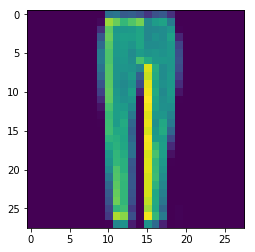

In [0]:
%matplotlib inline
import random as r

#loadedImg = validLoader.dataset.data[26] # Change value in the box to test on different images
num = r.randint(0, 10000)
loadedImg = validSet.test_data[num]
loadedLabel = validSet.test_labels[num].numpy()
plt.imshow(loadedImg)
loadedImg = loadedImg.to(device)
loadedImg = loadedImg[None, None]
loadedImg = loadedImg.type('torch.cuda.FloatTensor') # instead of DoubleTensor

out_predict = model(loadedImg)
#print (out_predict)
pred = out_predict.max(1, keepdim=True)[1]
#print (pred)

print("\n\tPredicted Label:", labelDict[pred.item()], "\n\tActual Label:", labelDict[loadedLabel.item()])

# Continue training from previous stored checkpoints


In [0]:
epoch = loadCheckpoint('checkpoints/mnist-015.pth')
print('Resuming training from epoch', epoch)
nextEpoch = epoch + 1
train(optimizer, model, num_epochs=3, first_epoch=nextEpoch)

Resuming training from epoch 15
Epoch: 16/3.. 


Training Loss: 0.183  
Test Loss: 0.264  
Test Accuracy: 90.467


Epoch: 17/3.. 


Training Loss: 0.177  
Test Loss: 0.251  
Test Accuracy: 91.050


Epoch: 18/3.. 


Training Loss: 0.172  
Test Loss: 0.266  
Test Accuracy: 90.699




In [0]:
!ls checkpoints

mnist-001.pth  mnist-005.pth  mnist-009.pth  mnist-013.pth  mnist-017.pth
mnist-002.pth  mnist-006.pth  mnist-010.pth  mnist-014.pth  mnist-018.pth
mnist-003.pth  mnist-007.pth  mnist-011.pth  mnist-015.pth
mnist-004.pth  mnist-008.pth  mnist-012.pth  mnist-016.pth
